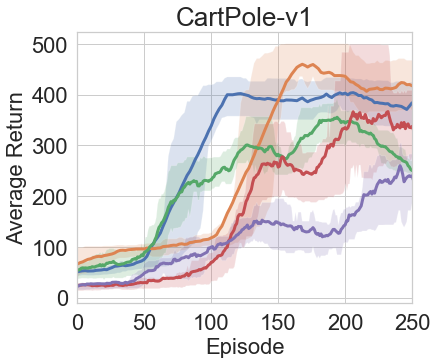

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

file_list = ['./log_files/dr_trpo_kl/CartPole-v1-1581924483.4587069.csv', './log_files/dr_trpo_wass/CartPole-v1-1581924172.541198.csv', './log_files/a2c/CartPole-v1-1583988257.742302.csv']
window_size = 30

def find_moving_avg(data, window_size):
    quantile1 = np.zeros(len(data)-window_size)
    quantile2 = np.zeros(len(data)-window_size)
    avg = np.zeros(len(data)-window_size)
    for i in range(len(data)-window_size):
        avg[i] = np.mean(data[i:i+window_size])
        quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
        quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
    return avg, quantile1, quantile2
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Episode', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,250)
plt.title('CartPole-v1', fontsize = 26)

for name in file_list:
    df=pd.read_csv(name, sep=',',header=None)
    if name.find('a2c') != -1:
        label = 'A2C'
        eps_per_iter = 1
    if name.find('kl') != -1:
        label = 'DRPO-KL'
        eps_per_iter = 2
    if name.find('wass') != -1:
        label = 'DRPO-Wass'
        eps_per_iter = 2
        
    x_val = df[0]
    y_val = df[1]
    moving_average = find_moving_avg(y_val, window_size)
    ax.plot(np.arange(len(x_val)-window_size)*eps_per_iter, moving_average[0], label=label, linewidth = 3)
    ax.fill_between(np.arange(len(x_val)-window_size)*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2)


# read TRPO baseline results
trpo_log_name = './tmp/trpo_cartpole_monitor6.csv'
window_size = 30
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
x_val = df['t']
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
ax.plot(np.arange(len(x_val)-window_size), moving_average[0], label='TRPO', linewidth = 3)
ax.fill_between(np.arange(len(x_val)-window_size), moving_average[1], moving_average[2], alpha=0.2)

# read PPO baseline results
trpo_log_name = './tmp/ppo_cartpole_monitor.csv'
window_size = 30
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
x_val = df['t']
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
ax.plot(np.arange(len(x_val)-window_size), moving_average[0], label='PPO', linewidth = 3)
ax.fill_between(np.arange(len(x_val)-window_size), moving_average[1], moving_average[2], alpha=0.2)

plt.rcParams["legend.framealpha"] = 0.5
# ax.legend(loc = 'lower right', fontsize = 15)

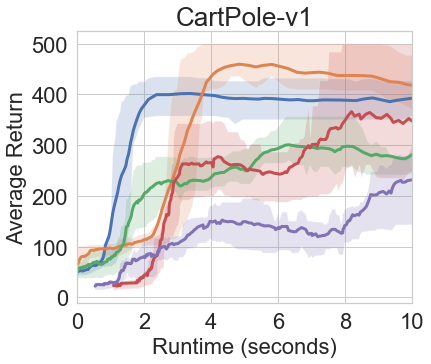

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

file_list = ['./log_files/dr_trpo_kl/CartPole-v1-1581924483.4587069.csv', './log_files/dr_trpo_wass/CartPole-v1-1581924172.541198.csv', './log_files/a2c/CartPole-v1-1583988257.742302.csv']
window_size = 30

def find_moving_avg(data, window_size):
    quantile1 = np.zeros(len(data)-window_size)
    quantile2 = np.zeros(len(data)-window_size)
    avg = np.zeros(len(data)-window_size)
    for i in range(len(data)-window_size):
        avg[i] = np.mean(data[i:i+window_size])
        quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
        quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
    return avg, quantile1, quantile2
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Runtime (seconds)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,10)
plt.title('CartPole-v1', fontsize = 26)

for name in file_list:
    df=pd.read_csv(name, sep=',',header=None)
    if name.find('a2c') != -1:
        label = 'A2C'
    if name.find('kl') != -1:
        label = 'DRPO-KL'
    if name.find('wass') != -1:
        label = 'DRPO-Wass'
        
    x_val = df[0]
    y_val = df[1]
    moving_average = find_moving_avg(y_val, window_size)
    ax.plot(x_val[:len(x_val)-window_size], moving_average[0], label=label, linewidth = 3)
    ax.fill_between(x_val[:len(x_val)-window_size], moving_average[1], moving_average[2], alpha=0.2)


# read TRPO baseline results
trpo_log_name = './tmp/trpo_cartpole_monitor6.csv'
window_size = 30
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
x_val = df['t']
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
ax.plot(x_val[:len(x_val)-window_size], moving_average[0], label='TRPO', linewidth = 3)
ax.fill_between(x_val[:len(x_val)-window_size], moving_average[1], moving_average[2], alpha=0.2)

# read PPO baseline results
trpo_log_name = './tmp/ppo_cartpole_monitor.csv'
window_size = 30
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
x_val = df['t']
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
ax.plot(x_val[:len(x_val)-window_size], moving_average[0], label='PPO', linewidth = 3)
ax.fill_between(x_val[:len(x_val)-window_size], moving_average[1], moving_average[2], alpha=0.2)

plt.rcParams["legend.framealpha"] = 0.5
# ax.legend(loc='lower right', fontsize = 15)

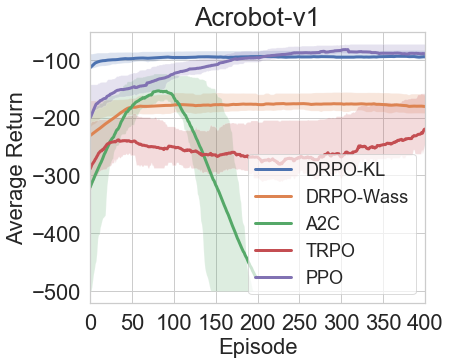

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

file_list = ['./log_files/dr_trpo_kl/Acrobot-v1-1586117014.473505.csv', './log_files/dr_trpo_wass/Acrobot-v1-1583979879.1119978.csv', './log_files/a2c/Acrobot-v1-1583971670.480433.csv']
window_size = 100

def find_moving_avg(data, window_size):
    quantile1 = np.zeros(len(data)-window_size)
    quantile2 = np.zeros(len(data)-window_size)
    avg = np.zeros(len(data)-window_size)
    for i in range(len(data)-window_size):
        avg[i] = np.mean(data[i:i+window_size])
        quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
        quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
    return avg, quantile1, quantile2
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Episode', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0, 400)
plt.title('Acrobot-v1', fontsize = 26)

for name in file_list:
    df=pd.read_csv(name, sep=',',header=None)
    if name.find('a2c') != -1:
        label = 'A2C'
        eps_per_iter = 1
    if name.find('kl') != -1:
        label = 'DRPO-KL'
        eps_per_iter = 3
    if name.find('wass') != -1:
        label = 'DRPO-Wass'
        eps_per_iter = 3
        
    x_val = df[0]
    y_val = df[1]
    moving_average = find_moving_avg(y_val, window_size)
    
    ax.plot(np.arange(len(x_val)-window_size)*eps_per_iter, moving_average[0], label=label, linewidth = 3)
    ax.fill_between(np.arange(len(x_val)-window_size)*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2)


# read TRPO baseline results
trpo_log_name = './tmp/trpo_acrobot_monitor9.csv'
window_size = 100
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
x_val = df['t']
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
ax.plot(np.arange(len(x_val)-window_size), moving_average[0], label='TRPO', linewidth = 3)
ax.fill_between(np.arange(len(x_val)-window_size), moving_average[1], moving_average[2], alpha=0.2)

# read PPO baseline results
trpo_log_name = './tmp/ppo_acrobot_monitor.csv'
window_size = 100
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
x_val = df['t']
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
ax.plot(np.arange(len(x_val)-window_size), moving_average[0], label='PPO', linewidth = 3)
ax.fill_between(np.arange(len(x_val)-window_size), moving_average[1], moving_average[2], alpha=0.2)

plt.rcParams["legend.framealpha"] = 0.7
ax.legend(loc='lower right', fontsize = 18)

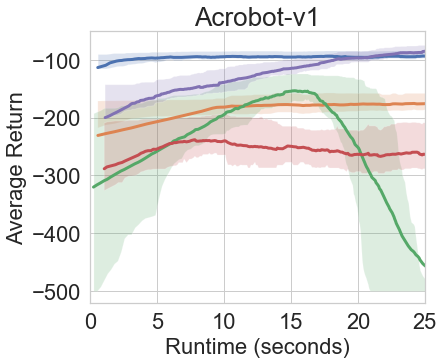

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

file_list = ['./log_files/dr_trpo_kl/Acrobot-v1-1586117014.473505.csv', './log_files/dr_trpo_wass/Acrobot-v1-1583979879.1119978.csv', './log_files/a2c/Acrobot-v1-1583971670.480433.csv']
window_size = 100

def find_moving_avg(data, window_size):
    quantile1 = np.zeros(len(data)-window_size)
    quantile2 = np.zeros(len(data)-window_size)
    avg = np.zeros(len(data)-window_size)
    for i in range(len(data)-window_size):
        avg[i] = np.mean(data[i:i+window_size])
        quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
        quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
    return avg, quantile1, quantile2
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Runtime (seconds)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,25)
plt.title('Acrobot-v1', fontsize = 26)

for name in file_list:
    df=pd.read_csv(name, sep=',',header=None)
    if name.find('a2c') != -1:
        label = 'A2C'
    if name.find('kl') != -1:
        label = 'DRPO-KL'
    if name.find('wass') != -1:
        label = 'DRPO-Wass'
        
    x_val = df[0]
    y_val = df[1]
    moving_average = find_moving_avg(y_val, window_size)
    ax.plot(x_val[:len(x_val)-window_size], moving_average[0], label=label, linewidth = 3)
    ax.fill_between(x_val[:len(x_val)-window_size], moving_average[1], moving_average[2], alpha=0.2)


# read TRPO baseline results
trpo_log_name = './tmp/trpo_acrobot_monitor9.csv'
window_size = 100
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
x_val = df['t']
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
ax.plot(x_val[:len(x_val)-window_size], moving_average[0], label='TRPO', linewidth = 3)
ax.fill_between(x_val[:len(x_val)-window_size], moving_average[1], moving_average[2], alpha=0.2)

# read PPO baseline results
trpo_log_name = './tmp/ppo_acrobot_monitor.csv'
window_size = 100
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
x_val = df['t']
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
ax.plot(x_val[:len(x_val)-window_size], moving_average[0], label='PPO', linewidth = 3)
ax.fill_between(x_val[:len(x_val)-window_size], moving_average[1], moving_average[2], alpha=0.2)

plt.rcParams["legend.framealpha"] = 0.5
# ax.legend(loc='lower right', fontsize = 15)